In [1]:
import pandas as pd
import numpy as np
from category_encoders import OrdinalEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import bayesian_optimization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings

In [2]:
# question 1: read adult data.txt as train, adult test.txt as test, rename their headers to ['age', 
# 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
# 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
column_name = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 
               'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
               'hours_per_week', 'native_country', 'wage_class']
df_train = pd.read_csv('adult+data.txt', header = None)
df_test = pd.read_csv('adult+test.txt', header = None)
df_train.columns = column_name
df_test.columns = column_name
print("train dataset shape is: " + str(df_train.shape))
print("test dataset shape is: " + str(df_test.shape))

train dataset shape is: (9674, 15)
test dataset shape is: (11182, 15)


In [3]:
# question 2: replace ‘ ?’ with nan and drop na
df_train_nona = df_train.replace(' ?', np.nan).dropna()
df_test_nona = df_test.replace(' ?', np.nan).dropna()
print("train dataset shape without '?' is: " + str(df_train_nona.shape))
print("test dataset shape without '?' is: " + str(df_test_nona.shape))

train dataset shape without '?' is: (8936, 15)
test dataset shape without '?' is: (10347, 15)


In [4]:
# question 3: replace test wage_class all of the ‘<=50K.’ 
# with ‘<=50K’ and the same for ‘>50K.’ with ‘>50K’, same as train
df_test_rep = df_test_nona.replace([' >50K.', ' <=50K.'], ['>50K', '<=50K'])
df_train_rep = df_train_nona.replace([' >50K', ' <=50K'], ['>50K', '<=50K'])

In [5]:
# question 4: apply Ordinal Encoding to Categoricals for both train and test
columns_object = df_train_rep.select_dtypes(include = 'object').columns
df_train_final = df_train_rep
df_test_final = df_test_rep
for i in df_train_rep.columns:
    if df_train_rep[i].dtype == 'object':
        encoder = OrdinalEncoder()
        df_train_final[i] = encoder.fit_transform(df_train_rep[i])
for i in df_test_rep.columns:
    if df_test_rep[i].dtype == 'object':
        encoder = OrdinalEncoder()
        df_test_final[i] = encoder.fit_transform(df_test_rep[i])
df_train_final['wage_class'] = df_train_final['wage_class'] - 1
df_test_final['wage_class'] = df_test_final['wage_class'] - 1
df_train_final.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,1,77516,1,13,1,1,1,1,1,2174,0,40,1,0
1,50,2,83311,1,13,2,2,2,1,1,0,0,13,1,0
2,38,3,215646,2,9,3,3,1,1,1,0,0,40,1,0
3,53,3,234721,3,7,2,3,2,2,1,0,0,40,1,0
4,28,3,338409,1,13,2,4,3,2,2,0,0,40,2,0


In [6]:
df_train_final['wage_class'].unique()

array([0, 1])

In [7]:
y_train = df_train_final['wage_class']
y_test = df_test_final['wage_class']
x_train = df_train_final.drop(columns = 'wage_class')
x_test = df_test_final.drop(columns = 'wage_class')

In [8]:
# question 5: build xgboost: wage_class is the response variable, and others are predictors
# use bayesian to find the best combination of tunning parameters:
# 'max_depth': (3,7) 'min_child_weight': (1,5), 'learning_rate': (0.01, 0.1), 'subsample': (0.7,0.9)
# 'colsample_bytree': (0.7,0.9), 'n_estimators': (1000, 2000), ' 'gamma': (0.01,1.)
def xgboostcv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, 
              subsample, colsample_bytree, silent = True, nthread = -1):
    return cross_val_score(xgb.XGBClassifier(max_depth = int(max_depth), learning_rate = learning_rate, 
                                             n_estimators = int(n_estimators), silent = silent, nthread = nthread, 
                                             gamma = gamma, min_child_weight = min_child_weight, subsample = subsample, 
                                             colsample_bytree = colsample_bytree),
                           x_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv=5).mean()

if __name__ == "__main__":
    
    xgboostBO = bayesian_optimization.BayesianOptimization(xgboostcv,
                                 {'max_depth': (3, 7),
                                  'learning_rate': (0.01, 0.1),
                                  'n_estimators': (1000, 2000),
                                  'gamma': (0.01, 1.),
                                  'min_child_weight': (1, 5),
                                  'subsample': (0.7, 0.9),
                                  'colsample_bytree' :(0.7, 0.9)})
    xgboostBO.maximize(init_points=2, n_iter = 10)
    print('-'*53)
    print('Final Results')
    temp = xgboostBO.res
    temp_list = []
    for i in temp:
        temp_list.append(i['target'])
    print('XGBOOST: %f' % max(temp_list))

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.918    |  0.8567   |  0.8171   |  0.01147  |  4.718    |  3.442    |  1.988e+0 |  0.7029   |
|  2        |  0.9089   |  0.7522   |  0.09978  |  0.03409  |  6.836    |  3.584    |  1.66e+03 |  0.8015   |
|  3        |  0.9052   |  0.7296   |  0.8534   |  0.09629  |  6.936    |  2.135    |  2e+03    |  0.8739   |
|  4        |  0.9118   |  0.9      |  1.0      |  0.01     |  3.0      |  5.0      |  1e+03    |  0.7      |
|  5        |  0.9135   |  0.8888   |  1.0      |  0.01     |  3.0      |  5.0      |  1.274e+0 |  0.7      |
|  6        |  0.9087   |  0.8469   |  0.7904   |  0.0363   |  6.82     |  1.066    |  1.839e+0 |  0.8013   |
|  7        |  0.9145   |  0.7982   |  0.5256   |  0.05028  |  3.055    |  4.92     |  1.459e+0 |  0.7279   |
|  8      

In [9]:
# question 6: use xgb.cv to find the early stopping rounds based on error
train_initial = xgb.DMatrix(x_train, y_train)
target_para = {}
for i in temp:
    if i['target'] == max(temp_list):
        target_para = i
param = {'eta': 0.01, 'seed':0, 'subsample': target_para['params']['subsample'], 
         'colsample_bytree': target_para['params']['colsample_bytree'], 'objective': 'binary:logistic', 
         'max_depth': int(target_para['params']['max_depth'].round()), 
         'min_child_weight': target_para['params']['min_child_weight'], 
         'gamma': target_para['params']['gamma']}
warnings.filterwarnings("ignore")
df_cv = xgb.cv(params = param, dtrain = train_initial, num_boost_round = 1000, 
               nfold = 5, metrics = ['error'], seed = 0, early_stopping_rounds = 100)
df_cv.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.161034,0.002462,0.174463,0.013897
1,0.148137,0.004938,0.159468,0.009311
2,0.146766,0.002765,0.160586,0.008914
3,0.141506,0.002025,0.155327,0.009329
4,0.142961,0.001548,0.153872,0.010867


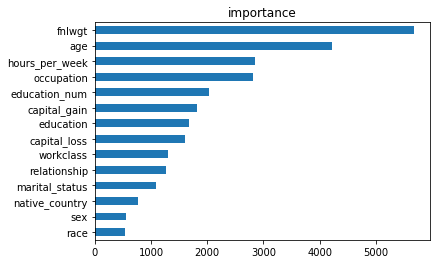

In [10]:
# question 7: plot feature importance
feature_imp = xgb.train(param, train_initial, num_boost_round = df_cv.shape[0])
imp_dict = feature_imp.get_score()
df_imp = pd.DataFrame.from_dict(imp_dict, orient = 'index')
df_imp.columns = ['importance']
df_imp = df_imp['importance'].sort_values()
df_imp.plot.barh()
plt.title('importance')
plt.show()

In [11]:
# question 8: analyze auc score on Test Data,
test_initial = xgb.DMatrix(x_test, y_test)
predict_result = feature_imp.predict(test_initial)
roc_auc_score(y_test, predict_result.round())

0.7005969160764121